# Shallow Learning Approach Revisited 

- Given Hyper Parameters Produces the Classifier Report
- Balancing of Dataset
- Preprocessing of Dataset
- Feature Extraction
- Classifier Report
    - Training Method (Simple Split, K Cross Validation [Metrics Averaged])
    - Classifier
        - Name
        - Hyperparameters
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - Senstivity
    - S..
    - FNR, FPR, TNR, TPR
    - AUC and ROC

In [1]:
# Hyper Parameters


PATCH_COUNT = 4

DISTANCES = [1, 2, 3]
ANGLES = [0, 45, 90, 135]
k_folds = 10


In [31]:
import os
import helper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

heatmap_paths = []
for current, subdir, files in os.walk("../ThermoDataBase"):
    for name in [ file for file in files if file.endswith("csv") ]:
        heatmap_paths += [ (f"{current}/{name}") ]


In [32]:
healthy_heatmap_paths = [ x for x in heatmap_paths if "DM Group" not in x ] 
diabetic_heatmap_paths = [x for x in heatmap_paths if "DM Group" in x]

random.shuffle(healthy_heatmap_paths)
random.shuffle(diabetic_heatmap_paths)

extra_diabetic_heatmap_paths = diabetic_heatmap_paths[len(healthy_heatmap_paths):]
diabetic_heatmap_paths = diabetic_heatmap_paths[:len(healthy_heatmap_paths)]


In [33]:
TEMP_MAX = 37
TEMP_MIN = 30
clahe = cv2.createCLAHE(clipLimit=50, tileGridSize=(3, 3))

def read_csv(path): return np.float64(pd.read_csv(path))
def tograyscale(heatmap):

    heatmap = np.where(heatmap >= TEMP_MIN, 1, 0) * heatmap
    heatmap = np.where(heatmap <= TEMP_MAX, 1, 0) * heatmap

    heatmap = np.uint8(((heatmap)/ TEMP_MAX) * 255)
    return heatmap
def preprocess(heatmap):
    mask = np.where(heatmap > 0, 1, 0)
    hist_equ = np.uint8(clahe.apply(heatmap) * mask)
    return hist_equ
    


In [34]:
heatmap = np.float32(pd.read_csv(heatmap_paths[0]))

print(f"{heatmap.max()=}, {heatmap.min()=}, {heatmap.mean()=}, {heatmap.std()=}", sep="\n")


heatmap.max()=np.float32(36.872), heatmap.min()=np.float32(0.0), heatmap.mean()=np.float32(26.168089), heatmap.std()=np.float32(15.270026)


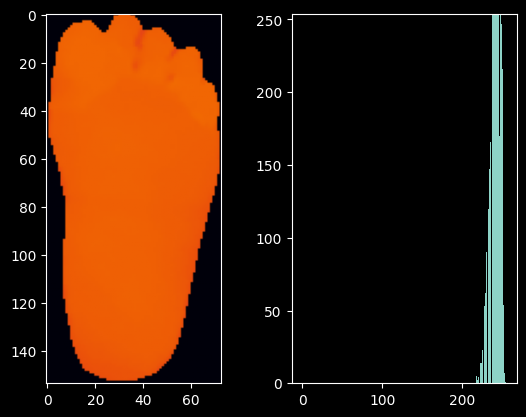

In [35]:
data = tograyscale(heatmap)


def plot_histogram(data, ax):
    count = np.zeros(256)
    for x in data.flatten():count[x] += 1
    ax.bar(x=np.arange(256), height=count)
    
    

fig, (img_ax, hist_ax) = plt.subplots(1, 2)
import cv2
img_ax.imshow(helper.ironbow_cmap(data))

hist_ax.set_ylim(bottom=0, top=data.max())
plot_histogram(data, hist_ax)


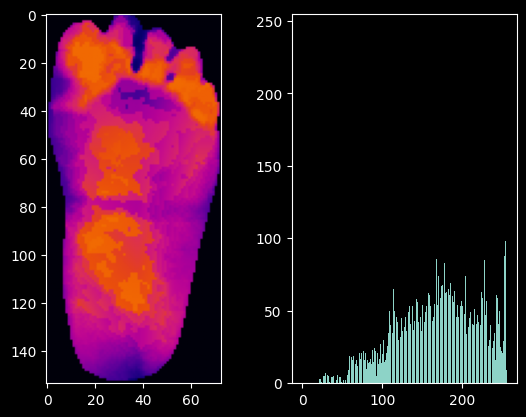

In [605]:
fig, (img_ax, hist_ax) = plt.subplots(1, 2)
import cv2
hist_equ = preprocess(data)
img_ax.imshow(helper.ironbow_cmap(hist_equ))

hist_ax.set_ylim(bottom=0, top=hist_equ.max())
plot_histogram(hist_equ, hist_ax)


Feature Extraction

Given a Thermogram we will utlize following methods of feature extraction.

1. GLCM (Grayscale Level Co-occurance Matrix).
    - Given Distance and Angle and a grayscale matrix Produces a Matrix [I, J] of shape (256, 256) such that value of m[i, j] represent a count of (i, j) at given distance offset and given angle. i.e a 2d histogram with given offset and angle constraints.


2. Histogramic Features

<Axes: >

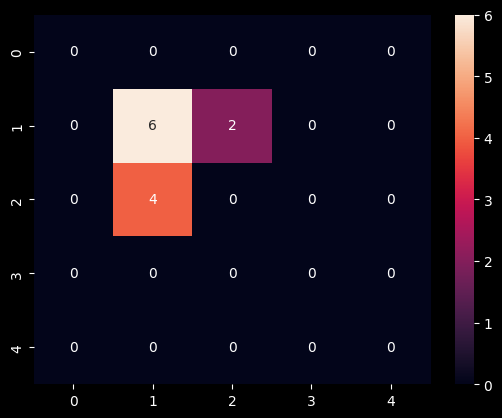

In [606]:
from IPython.display import display_pretty
import numpy as np
mat = np.array([
    [1, 2, 2, 1],
    [1, 1, 1, 1],
    [1, 2 ,2, 1],
    [1, 1, 1, 1]
], dtype=np.uint8)
from skimage.feature import graycomatrix

glcm = graycomatrix(mat, distances=[1], angles=[90])[:5, :5, 0, 0]
import matplotlib.pyplot as plt

import seaborn as sns

sns.heatmap(glcm,annot=True)

In [607]:
from skimage.feature import graycomatrix, graycoprops

def getGLCMProps(distances, angles, thermogram):
    text_props = [ "contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation" ] 

    mat = graycomatrix(thermogram, distances, angles, normed=True)
    props = []
    for prop in text_props:
        p = graycoprops(mat, prop).flatten()
        props += [ p ]
    props = np.array(props).flatten()
    return props



def getHistgramFeatures(thermogram):
    mean, variance, entropy, skew = 0, 0, 0, 0
    hist = np.zeros(256)
    for x in thermogram.flatten(): hist[x] += 1
    s = sum(hist)

    hist_p = hist / s

    for x in range(256):
        mean += x * hist_p[x]


    for x in range(256):
        variance += hist_p[x] * ((x - mean) **2)
        entropy += hist_p[x] * np.log2(hist_p[x]) if hist_p[x] > 0 else 0


    for x in range(256):
        skew += ((1 / variance)**3)*((x - mean)**3)*hist_p[x] if variance > 0 else 0
    return [ mean, variance, entropy, skew ]

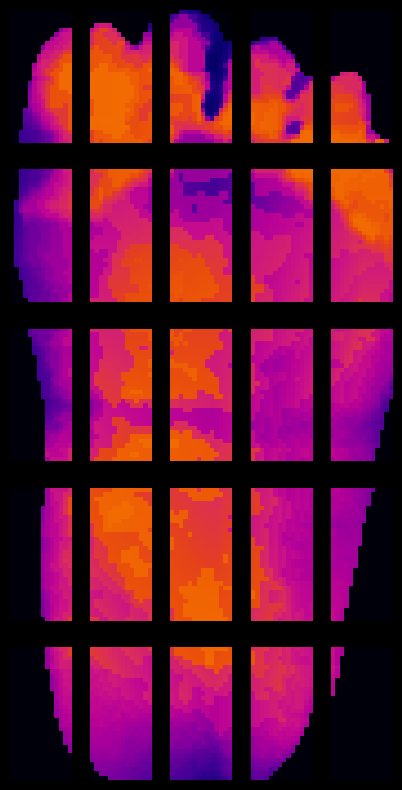

In [608]:


def getPatch(index_x, index_y, patch_count, thermogram):
    ps_y, ps_x = np.array(thermogram.shape) // patch_count
    return thermogram[index_y * ps_y: (index_y + 1) * ps_y, index_x * ps_x: (index_x + 1) * ps_x]



def visual_patches(patch_count, thermogram, weighted = None):
    fig, ax = plt.subplots(patch_count, patch_count, figsize=(5, 10))

    if type(ax) is not np.ndarray:
        patch = getPatch(0, 0, patch_count, thermogram)
        ax.imshow(helper.ironbow_cmap(patch))
    else:
        
        for x in range(0, patch_count):
            for y in range(0, patch_count):
                patch = getPatch(x, y, patch_count, thermogram)
                patch = helper.ironbow_cmap(patch)
                if weighted is not None:
                    index = x + y * patch_count
                    weight = weighted[index]
                    patch = patch * weight 
                ax[y][x].imshow(patch)
                ax[y][x].axis("off")
    plt.show()

visual_patches(PATCH_COUNT, hist_equ)


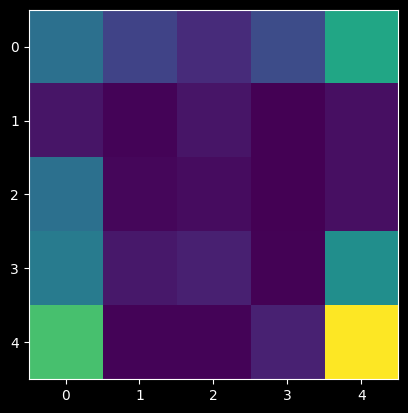

In [609]:
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




def getPatchFeatures(distances, angles, patch):
    glcm_prop = getGLCMProps(distances, angles, patch)
    hist_feat = getHistgramFeatures(patch)
    feature_patch = []
    feature_patch += hist_feat 
    feature_patch += [ *glcm_prop ] 
    feature_patch = np.array(feature_patch)
    return feature_patch.flatten()
    

def getFeatureMap(distances, angles, patch_count, thermogram):
    x, y = np.meshgrid(np.arange(PATCH_COUNT), np.arange(PATCH_COUNT))
    feature_map = []
    for x, y in zip(x.flatten(), y.flatten()):
        patch = getPatch(x, y, patch_count, thermogram)
        feature_map += [ getPatchFeatures(distances, angles, patch) ]
        
    feature_map = np.array(feature_map)
    
    feature_map = StandardScaler().fit_transform(feature_map)
    feature_map = PCA(n_components=1).fit_transform(feature_map)
    return feature_map


feature_map = getFeatureMap(DISTANCES, ANGLES, PATCH_COUNT, hist_equ)
plt.imshow(feature_map.reshape(PATCH_COUNT, PATCH_COUNT))

# Threading Work


```python
(IID, PID, DATA) --> (IID, PID, Features)

Function():
    while work_on_going:
        iid, pid, data = fetch_work() [atmoic]
        features = do_work(data)
        feature_set[iid][pid] = features
```       

In [610]:


import threading

work_lock = threading.Lock()
dataset = [ [ [] for _ in range(PATCH_COUNT**2) ] for __ in range(len(heatmap_paths)) ]
forced_stop = False

def worker(tid, distances, angles):
    # print(f"{tid}: Started!")
    while not forced_stop:
        work_lock.acquire()
        work = None
        if len(work_loads) > 0:
            work = work_loads.pop()
        else:
            work_lock.release()
            break
        work_lock.release()
        iid, pid, data = work
        # print(f"{iid, pid}: Work Assigned!")
        patch_feature = getPatchFeatures(distances, angles, data)
        pid = pid[0] + pid[1] * PATCH_COUNT
        dataset[iid][pid] = patch_feature
    # print(f"{tid}: Completed!")

In [611]:
work_loads = []
for iid, path in enumerate(heatmap_paths):
    thermogram = preprocess(tograyscale(read_csv(path)))
    x, y = np.meshgrid(np.arange(PATCH_COUNT), np.arange(PATCH_COUNT))
    for x, y in zip(x.flatten(), y.flatten()):
        pid = (x, y)
        patch = getPatch(x, y, PATCH_COUNT, thermogram)
        work_loads += [ (iid, pid, patch) ]

In [612]:
THREAD_POOL = 8
total = len(work_loads)
from ipywidgets import FloatProgress
from IPython.display import display
import time


progress_bar = FloatProgress(min=0, max=100,value=0, description="Feature Computation")
display(progress_bar)
workers = [ threading.Thread(target=worker, args=(tid, DISTANCES, ANGLES)) for tid in range(THREAD_POOL)]

for thread in workers:
    thread.start()
try:
    for thread in workers:
        while thread.is_alive():
            thread.join(5)
            rem = len(work_loads)
            progress = 100 * ((total - rem)) / total
            progress_bar.value = progress
except:
    forced_stop = True
    pass
        


# Time, Thread Count, Verbose = 5m 17.2sec,  8, True
# Time, Thread Count, Verbose = 5m 10.2sec,  8, False
# Time, Thread Count, Verbose = 3m 52.2sec, 12, False
# Time, Thread Count, Verbose = 3m 42.2sec, 20, False

# Time: 71min, Patch: 16
# Time: 1m, 29sec, Patch: 4, Thread Count 8

#Time: 20min, Patch Count : 8, Thread Count 8

FloatProgress(value=0.0, description='Feature Computation')

In [613]:
from sklearn.model_selection import train_test_split

dataset = np.array(dataset)

dataset = dataset.reshape(dataset.shape[0], -1)
y = np.array([ 1 if "DM Group" in path else 0 for path in heatmap_paths ])


<Axes: >

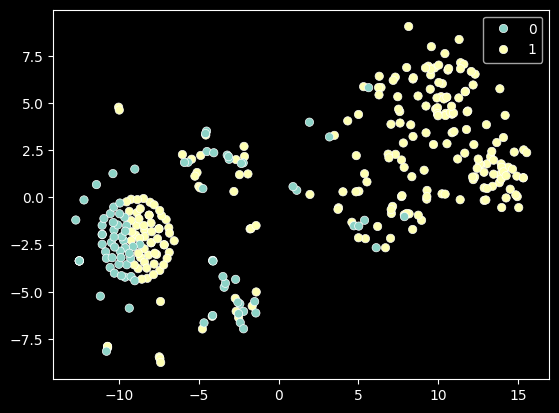

In [614]:
from sklearn.manifold import TSNE
import seaborn as sea

tsne = TSNE(n_components=2)
data_2 = tsne.fit_transform(dataset)

sea.scatterplot(x=data_2[:, 0], y=data_2[:, 1], hue=y)


In [615]:
k = np.array(list(enumerate(y)))
dia_index = np.array([ x for x in k if x[-1] == 1])
heal_index = np.array([ x for x in k if x[-1] == 0])

extra_dia_index = dia_index[len(heal_index):]
dia_index = dia_index[:len(heal_index)]

dia_bal = [ dataset[index] for index, val  in dia_index ]
heal_bal = [ dataset[index] for index, val in heal_index ]

extra_dia = [dataset[index] for index, val in extra_dia_index ]

bal_df = np.c_[np.array([*dia_bal, *heal_bal]), [ *([1]*len(dia_bal)), *([0]*len(heal_bal)) ]]
np.random.shuffle(bal_df)

x_dataset = bal_df[:, :-1]
y = bal_df[:, -1]



In [616]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y)

Dimensinality Reduction and Scaling

In [617]:
patch_scaler = StandardScaler()
pca = PCA(n_components=PATCH_COUNT*PATCH_COUNT)

x_train = patch_scaler.fit_transform(x_train)
x_test = patch_scaler.transform(x_test)

x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


Classifiers

1. SVM.
2. Decision Tree.
3. Naive Baise
4. Logistic Regression

In [618]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


dict_classifier = {
    "SVC Linear" : SVC(kernel="linear"),
    "SVC RBF" : SVC(kernel="rbf"),
    "Logistic Regression" : LogisticRegression(),
    "Logistics Regression L2" : LogisticRegression(penalty="l2"),
    "KNN 3" : KNN(n_neighbors=3),
    "Decision Tree" : DecisionTreeClassifier()
}



[ clas.fit(x_train, y_train) for clas in dict_classifier.values() ]



def metrics(classifier):
    metric_funcs = [ accuracy_score, precision_score, recall_score, f1_score ]
    pred = classifier.predict(x_test)
    return [ func(pred, y_test) for func in metric_funcs ]

metric_scores = np.array([ metrics(clas) for clas in dict_classifier.values()])

/home/someone/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/someone/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

,classifier,accuracy,precision,recall,f1 score
0,SVC Linear,0.777778,0.636364,0.875000,0.736842
1,SVC RBF,0.644444,0.454545,0.714286,0.555556
2,Logistic Regression,0.755556,0.590909,0.866667,0.702703
3,Logistics Regression L2,0.755556,0.590909,0.866667,0.702703
4,KNN 3,0.666667,0.500000,0.733333,0.594595
5,Decision Tree,0.622222,0.545455,0.631579,0.585366


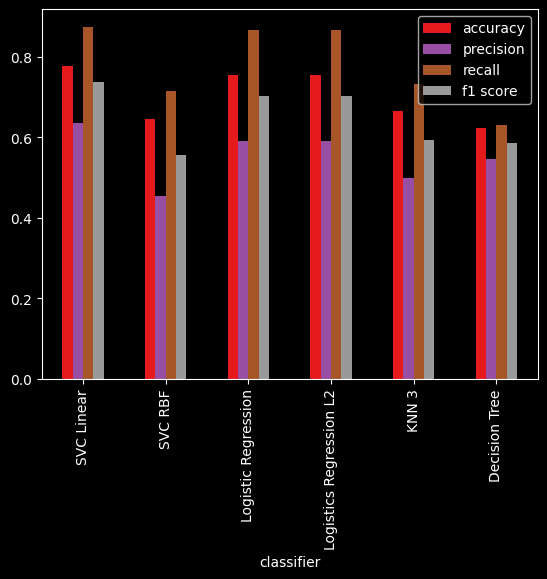

In [619]:
from sklearn.metrics import f1_score


import seaborn as sea

data={
    "classifier" : dict_classifier.keys(),
    "accuracy" : metric_scores[:, 0],
    "precision" : metric_scores[:, 1],
    "recall" : metric_scores[:, 2],
    "f1 score" : metric_scores[:,3]

}

df = pd.DataFrame(data)

df.plot(kind="bar", x="classifier", colormap="Set1")

display(df)

In [620]:
def posnorm(arr):
    arr = np.abs(arr)
    arr = arr - np.min(arr)
    arr = arr / np.max(arr)
    arr = arr.flatten()
    return arr


def visual_classifier_weighted_patches(classifier, thermogram):
    coef = classifier.coef_
    coef = posnorm(coef)
    visual_patches(PATCH_COUNT, hist_equ, coef)

SVC Linear


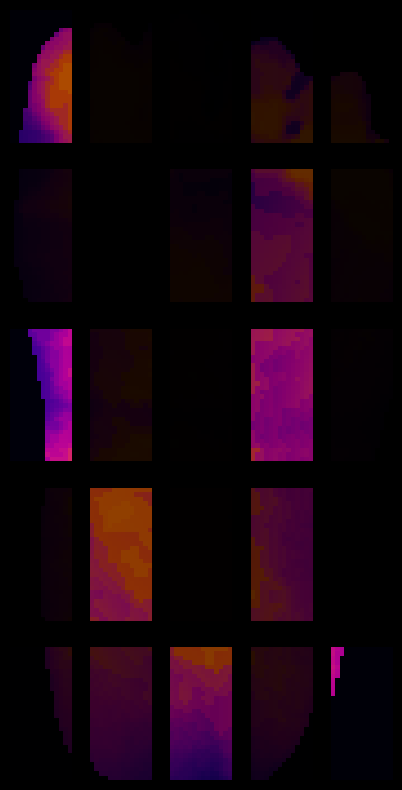

Logistic Regression


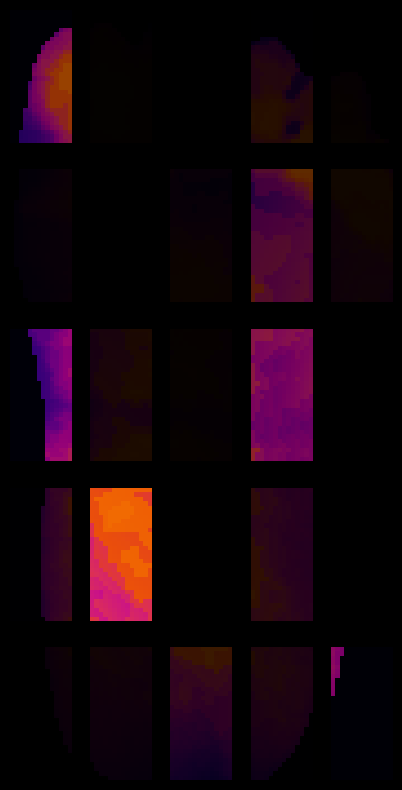

Logistics Regression L2


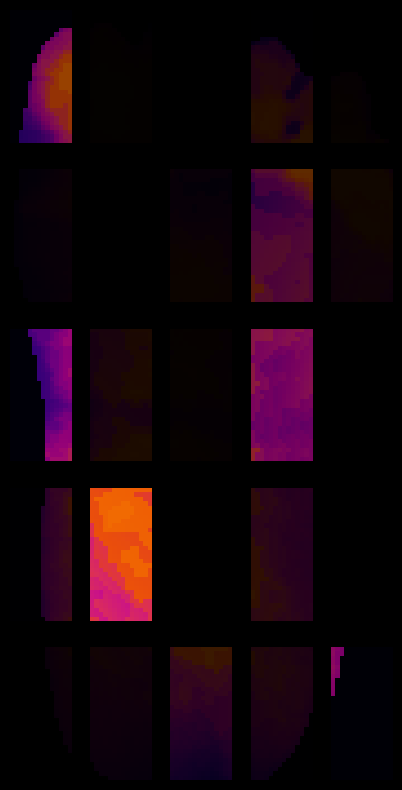

In [621]:
for name, clas in dict_classifier.items():
    if not ("Linear" in name or "Logistic" in name):
        continue
    print(name)
    visual_classifier_weighted_patches(clas, hist_equ)

# Evaluating Classifier

1. Confusion Matrix
2. Accuracy
3. Precision
4. Recall
5. F1-Score
6. AUC and ROC ?
7. Sensitivity
8. Se..
9. FNR
10. TNR

# K Cross Validation

In [622]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


def kfold_cv(k, classifier, dataset, y):
    kfold = KFold(n_splits=k, shuffle=True)

    test_accs = []
    train_accs = []

    for train, test in kfold.split(dataset, y):
        x_train = dataset[train]
        x_test  = dataset[test]

        y_train = y[train]
        y_test = y[test]
        patch_scaler = StandardScaler()
        pca = PCA(n_components=PATCH_COUNT*PATCH_COUNT)
        x_train = patch_scaler.fit_transform(x_train)
        x_test = patch_scaler.transform(x_test)
        x_train = pca.fit_transform(x_train)
        x_test = pca.transform(x_test)
        classifier.fit(x_train, y_train)

        y_train_pred = classifier.predict(x_train)
        y_test_pred = classifier.predict(x_test)
        train_accs += [ accuracy_score(y_train_pred, y_train) ]
        test_accs  += [ accuracy_score(y_test_pred, y_test)]
    
    return train_accs, test_accs




def visual_kfold_acc(k, train_accs, test_accs, title):
    mtr, mta = (np.mean(train_accs), np.mean(test_accs))
    print(f"Average Training Accuracy {k}fold: ", mtr)
    print(f"Average Tesing Accuracy {k}fold: ", mta)
    plt.plot([*range(k)], train_accs, "co-", label="Training Accuracy")
    plt.plot([*range(k)], test_accs, "mo-", label="Testing Acc")
    plt.plot([*range(k)], [mtr]*k, "co--", label="Average Training Accuracy")
    plt.plot([*range(k)], [mta]*k, "mo--", label="Average Testing Accuracy")
    plt.legend()
    plt.title(title)
    plt.show()


Average Training Accuracy 10fold:  0.8864197530864196
Average Tesing Accuracy 10fold:  0.7611111111111111


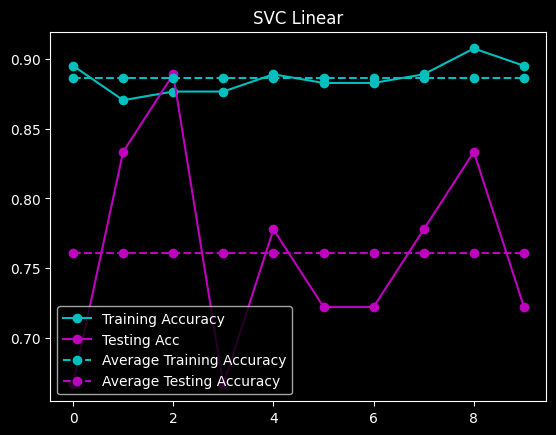

Average Training Accuracy 10fold:  0.85
Average Tesing Accuracy 10fold:  0.7777777777777778


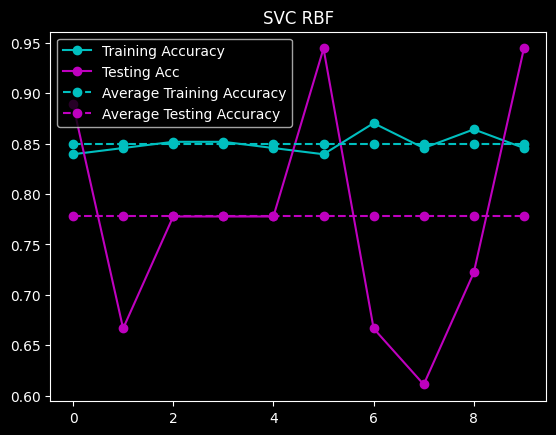

/home/someone/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/someone/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Average Training Accuracy 10fold:  0.8734567901234567
Average Tesing Accuracy 10fold:  0.788888888888889


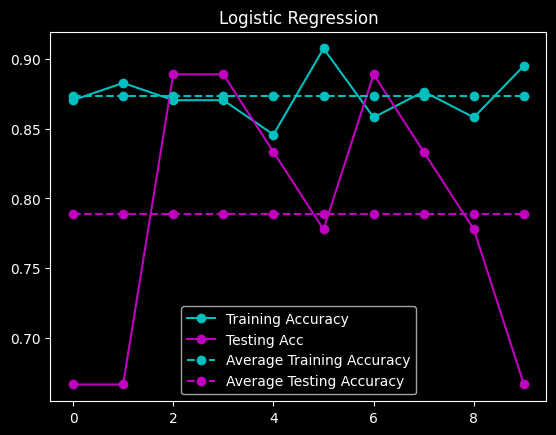

/home/someone/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/someone/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Average Training Accuracy 10fold:  0.8753086419753086
Average Tesing Accuracy 10fold:  0.7666666666666667


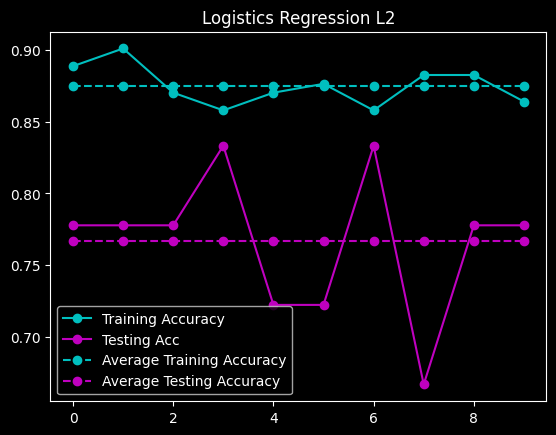

Average Training Accuracy 10fold:  0.8067901234567902
Average Tesing Accuracy 10fold:  0.7222222222222222


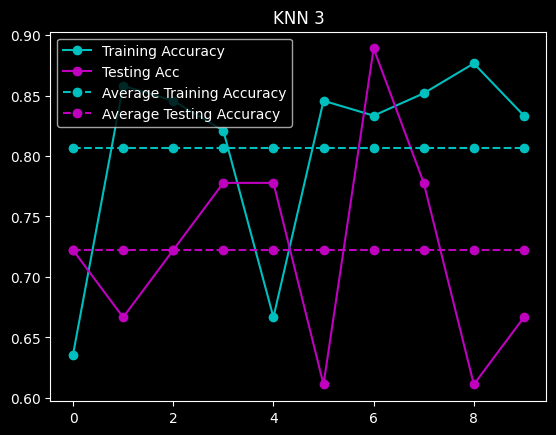

Average Training Accuracy 10fold:  0.9277777777777778
Average Tesing Accuracy 10fold:  0.7722222222222224


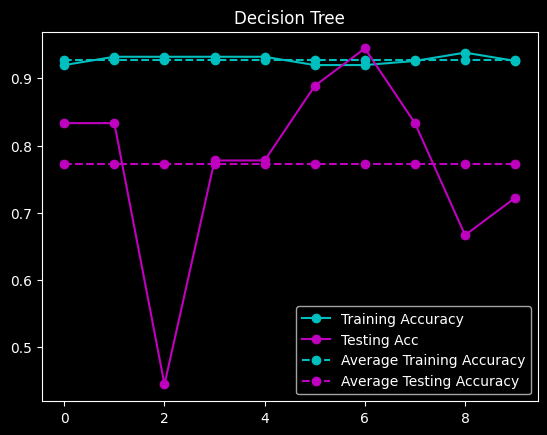

In [623]:
from sklearn.linear_model import LogisticRegression


for name, clas in dict_classifier.items():
    train_accs, test_accs = kfold_cv(k_folds, clas, x_dataset, y)
    visual_kfold_acc(k_folds, train_accs, test_accs, name)

